# Graph Partitioning with a QUBO objective function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from graphs import DrawSolution, NetworkToFile, FileToNetwork
from graphs import DrawNetwork, GraphPartitioning, RandomGraphGenerator

We will try to explore the GP problem using the QUBO model, in which the objective function is given by

$$ E(\mathbf{x}) = \sum_i Q_{ii} x_i + \sum_{i < j} Q_{ij} x_i x_j $$

where $x_i \in \{0, +1 \}$. We will try to minimize  this function or, equivalently, to find

$$ \min_{\mathbf{x}}{\mathbf{x}^T Q \mathbf{x}} $$

where $\mathbf{x} \in \{0, +1 \}^n$.

Given a graph $G = (V, E)$ with vertex set $V$ and edge set $E$ such that $n = |V|$ and $m = |E|$, it can be shown that in the GP problem the matrix $Q$ is as follows


$$Q_{ij} = \begin{cases}
        \alpha - \beta , \quad &(i, j) \in E\\
        \alpha, \quad &(i, j) \notin E, \, i \neq j\\
        \beta g_i - \alpha(n-1), \quad &i = j
    \end{cases}$$

where $g_i$ is de degree of the vertex $i$ and 

$$\frac{\alpha}{\beta} \geq \frac{\min(2 \Delta, n)}{8}$$

where $\Delta$ is the maximal degree of the graph. We will study this problem for different values of $\alpha$ and $\beta$.

In [29]:
def QMatrix(fileName, alpha, beta):
    '''
    This function returns the Q matrix for a given graph
    
    Input
    -----
    fileName  : string
                name of the file containing the graph
    alpha     : double
                weight for the balancing constraint
    beta      : double
                weight for the minimum edge cut size
    
    Output
    ------
    Q  : array
         Q matrix for the QUBO optimization problem
    '''
    
    vertex = []
    gi = []
    
    #Getting the information of the graph
    with open(fileName) as file:
        
        next(file) #discard line
        n, m = [int(x) for x in next(file).split()]
        
        for i in range(n):
            vertex.append([])
            gi.append([])
        
        #Degrees
        i = 0   
        for line in file:
            e = line.split()
            gi[i] = len(e)
            for j in range(len(e)):
                vertex[i].append(int(e[j]))
            i += 1
            

        #Building the Q matrix
        Q = np.full((n,n), alpha)
        
        for i in range(n):
            Q[i][i] = beta*gi[i] - alpha*(n-1)
        for i in range(len(vertex)):
            for j in range(len(vertex[i])):
                Q[i][vertex[i][j]-1] = alpha - beta
    return Q 

In [3]:
def QUBOSolution(Q, tol):
    '''
    Finds the solutions of the minimization problem
    
    Input
    -----
    Q    : array
           Q matrix for the QUBO optimization problem
    tol  : double
           tolerance for the minimum value
    
    Output
    ------
    num_sols  : double
                number of solutions         
    xmin      : array
                solutions to the GP problem
    Egap      : double
                energy gap
    
    '''
    
        
    #Preparing all possible vectors
    x = itertools.product([0,1], repeat = len(Q))
    list_x = list(x)
    
    #Verifying the number of combinations
    if (len(list_x)) != 2**len(Q):
        print("Not all vectors found \n")
        return None
    
    #Finding the solution
    sol = np.zeros(len(list_x))
    aux = 0
    for i in range(len(list_x)):
        aux = np.matmul(list_x[i], Q)
        sol[i] = np.matmul(aux, list_x[i])
    
    E = np.amin(sol)
    min_list = np.isclose(sol, E, atol = tol)
        
    xmin = []
    gap = []
    i = 0
    for item in min_list:
        if item == True:
            xmin.append(list_x[i])
        else:
            gap.append(sol[i])
        i += 1
    num_sols = len(xmin)
    
    #Energy gap
    E2 = np.amin(gap)
    Egap = E2-E
                
    return num_sols, xmin, Egap

In [4]:
def CheckIfEqual(fileName, xmin):
    '''
    Checks if any solution is equal to the solution found by METIS
    
    Input
    -----
    fileName  : string
                name of the file with the METIS solution
    xmin      : array
                QUBO solutions
    '''
    
    metis = []
    #Reading METIS solution
    with open(fileName) as file:
        for line in file:
            i = line.split()
            metis.append(int(i[0]))
    metis = np.array(metis)
    
    #Comparing
    for i in range(len(xmin)):
        sol = np.array(xmin[i])
        
        if (metis == sol).all():
            return True
        
    #Not found
    return False

In [21]:
def NumberCutEdges(partition, network):
    '''
    Returns the number of cut edges of a partition
    
    Input
    -----
    partition   : array
                  partition of the vertices
    network     : networkx graph
                  graph that has been partitioned
    
    Output
    ------
    cut_edges  : int
                 number of cut edges  
    '''
    
    edge_list = list(network.edges)
    cut_edges = 0
    for edge in edge_list:
        cut_edges += (partition[edge[0]] - partition[edge[1]])**2
        
    return cut_edges 

In [22]:
def IsConnected(partition, network):
    '''
    Checks if a solution gives a connected partition or not
    
    Input
    -----
    partition   : array
                  partition of the vertices
    network     : networkx graph
                  graph that has been partitioned               
    '''
    
    #Making sure edges are well-ordered
    edge_list = list(network.edges())
    e = 0
    for item in edge_list:
        if (item[1] < item[0]):
            edge_list[e] = (item[1], item[0])
        e += 1
        
    #Checking if connected
    for i in range(len(partition)-1):
        if partition[i] == partition[i+1]:
            if ((i, i+1) not in edge_list):
                return False
            
    return True

In [23]:
def IsBalanced(partition):
    '''
    Checks if a solution gives a balanced partition or not
    
    Input
    -----
    partition   : array
                  partition of the vertices            
    '''
    count1=0
    count2=0
    
    for item in partition:
        if (item == 0):
            count1 += 1
        else:
            count2 += 1
    if (count1 == count2):
        return True
    else:
        return False

## First example

We will try to first to solve the problem using the following graph:

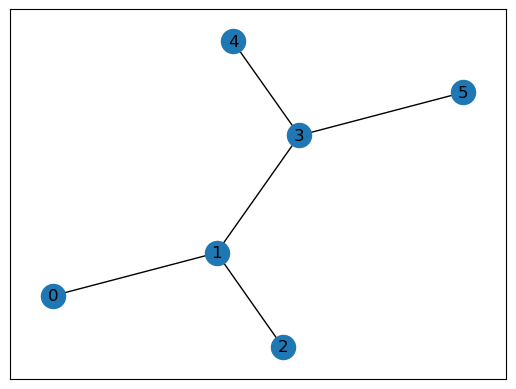

In [24]:
H = FileToNetwork("example1.txt")
DrawNetwork(H, "example1.png")

Now $\frac{\alpha}{\beta} \geq 0.75$. However, we will fix $\beta = 1$ and we will choose $\alpha \in [0, 1.5]$ to study how this parameters afect the result.

In [25]:
beta = 1
alpha_values = np.linspace(0, 1.5, 15)

In [26]:
#METIS solution
GraphPartitioning("example1.txt", 2)

******************************************************************************
METIS 5.0 Copyright 1998-13, Regents of the University of Minnesota
 (HEAD: , Built on: Nov  5 2021, 13:09:47)
 size of idx_t: 32bits, real_t: 64bits, idx_t *: 64bits

Graph Information -----------------------------------------------------------
 Name: example1.txt, #Vertices: 6, #Edges: 5, #Parts: 2

Options ---------------------------------------------------------------------
 ptype=kway, objtype=cut, ctype=shem, rtype=greedy, iptype=metisrb
 dbglvl=0, ufactor=1.030, no2hop=NO, minconn=NO, contig=NO, nooutput=NO
 seed=-1, niter=10, ncuts=1

Direct k-way Partitioning ---------------------------------------------------
 - Edgecut: 1, communication volume: 2.

 - Balance:
     constraint #0:  1.000 out of 0.333

 - Most overweight partition:
     pid: 0, actual: 3, desired: 3, ratio: 1.00.

 - Subdomain connectivity: max: 1, min: 1, avg: 1.00

 - Each partition is contiguous.

Timing Information -------------

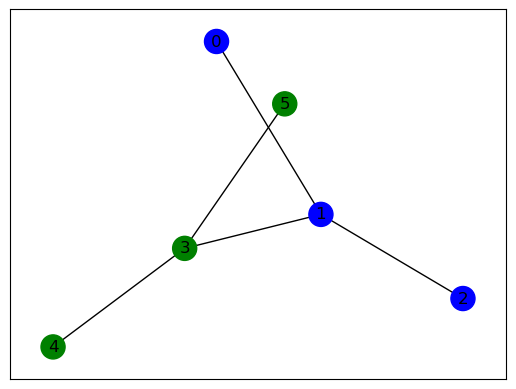

In [27]:
DrawSolution(H, "example1.txt.part.2", "example1.part.plot.png")

In [30]:
xmin = []
print("alpha" + "\t  " + "num solutions" + "\t\t" + "equal" + "\t\t" + "solution")
for alpha in alpha_values:
    Q =QMatrix("example1.txt", alpha, beta)
    num_sols, xmin_aux, Egap = QUBOSolution(Q, 1e-2)
    xmin.append(xmin_aux)
    solution = CheckIfEqual("example1.txt.part.2", xmin_aux)
    print("{0:.2f}".format(alpha)+ "\t\t" + str(num_sols) + "\t\t" + str(solution) + "\t\t" + str(xmin_aux))

alpha	  num solutions		equal		solution
0.00		2		False		[(0, 0, 0, 0, 0, 0), (1, 1, 1, 1, 1, 1)]
0.11		2		False		[(0, 0, 0, 0, 0, 0), (1, 1, 1, 1, 1, 1)]
0.21		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
0.32		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
0.43		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
0.54		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
0.64		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
0.75		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
0.86		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
0.96		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
1.07		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
1.18		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
1.29		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
1.39		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]
1.50		2		True		[(0, 0, 0, 1, 1, 1), (1, 1, 1, 0, 0, 0)]


## Second example (dodecahedral graph)

We will try to solve the problem now for the dodecahedral grap, of $n = 20$ vertices and $e = 30$ edges. Each vertex has degree 3, therefore $\frac{\alpha}{\beta} \geq 0.75$. We will fix again $\beta = 1$ and choose $\alpha \in [0, 1.5]$.

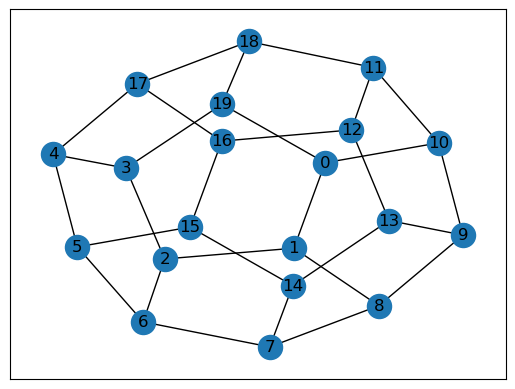

In [31]:
G = FileToNetwork("example2.txt")
DrawNetwork(G, "example2.png")

In [32]:
beta = 1
alpha_values = np.linspace(0, 1.5, 15)

In [33]:
#METIS solution
GraphPartitioning("example2.txt", 2)

******************************************************************************
METIS 5.0 Copyright 1998-13, Regents of the University of Minnesota
 (HEAD: , Built on: Nov  5 2021, 13:09:47)
 size of idx_t: 32bits, real_t: 64bits, idx_t *: 64bits

Graph Information -----------------------------------------------------------
 Name: example2.txt, #Vertices: 20, #Edges: 30, #Parts: 2

Options ---------------------------------------------------------------------
 ptype=kway, objtype=cut, ctype=shem, rtype=greedy, iptype=metisrb
 dbglvl=0, ufactor=1.030, no2hop=NO, minconn=NO, contig=NO, nooutput=NO
 seed=-1, niter=10, ncuts=1

Direct k-way Partitioning ---------------------------------------------------
 - Edgecut: 6, communication volume: 12.

 - Balance:
     constraint #0:  1.000 out of 0.100

 - Most overweight partition:
     pid: 0, actual: 10, desired: 10, ratio: 1.00.

 - Subdomain connectivity: max: 1, min: 1, avg: 1.00

 - Each partition is contiguous.

Timing Information --------

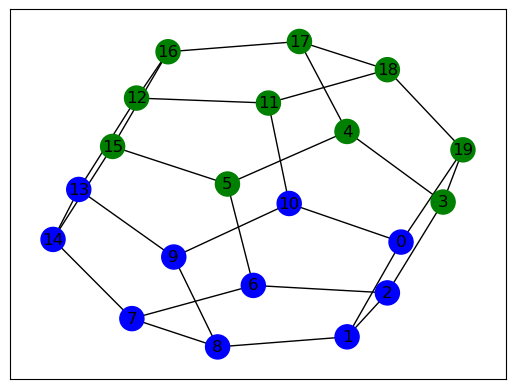

In [34]:
DrawSolution(G, "example2.txt.part.2", "example2.part.plot.png")

In [35]:
xmin = []
print("alpha" + "\t" + "num sol" + "\t  " + "equal" + "\t  " + "cut edges")
for alpha in alpha_values:
    
    Q =QMatrix("example2.txt", alpha, beta)
    num_sols, xmin_aux, Egap = QUBOSolution(Q, 1e-2)
    xmin.append(xmin_aux)
    solution = CheckIfEqual("example2.txt.part.2", xmin_aux)

    edge_list = []
    for vect in xmin_aux:
        edge_list.append(NumberCutEdges(vect, G))
    cut_edge_min = np.amin(edge_list) 
    index = np.where(edge_list == cut_edge_min)  
        
    print("{0:.2f}".format(alpha)+ "\t   " + str(num_sols) + "\t  " + str(solution) + "\t     " + str(cut_edge_min))

alpha	num sol	  equal	  cut edges
0.00	   2	  False	     0
0.11	   20	  True	     6
0.21	   20	  True	     6
0.32	   20	  True	     6
0.43	   20	  True	     6
0.54	   20	  True	     6
0.64	   20	  True	     6
0.75	   20	  True	     6
0.86	   20	  True	     6
0.96	   20	  True	     6
1.07	   20	  True	     6
1.18	   20	  True	     6
1.29	   20	  True	     6
1.39	   20	  True	     6
1.50	   20	  True	     6


Let's check if all solutions are balanced and connected.

In [36]:
balance_list = []
connected_list = []
for item in xmin:
    b1 = []
    c1 = []
    for sol in item:
        b1.append(IsBalanced(sol))
        c1.append(IsConnected(sol, G))
        
    temp1 = True
    
    for i in b1:
        if temp1 != i:
            temp1 = False
            break;
    temp2 = True
    
    for i in c1:
        if temp2 != i:
            temp2 = False
            break;
            
    balance_list.append(temp1)
    connected_list.append(temp2)
    
print("All balanced?")  
print(balance_list)
print("\n")

print("All connected?")  
print(connected_list) 

All balanced?
[False, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


All connected?
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


## Extreme cases

In [39]:
n = 10
p = 0.3
I = RandomGraphGenerator(n, p)

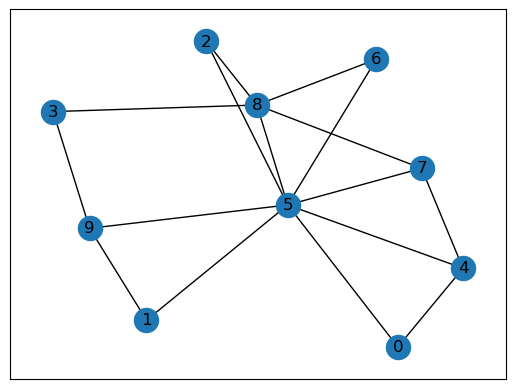

In [40]:
NetworkToFile(I, "example5.txt")
DrawNetwork(I, "example5.png")

In [41]:
beta = 1
alpha_values = np.linspace(0, 1.5, 15)

In [42]:
#METIS solution
GraphPartitioning("example5.txt", 2)

******************************************************************************
METIS 5.0 Copyright 1998-13, Regents of the University of Minnesota
 (HEAD: , Built on: Nov  5 2021, 13:09:47)
 size of idx_t: 32bits, real_t: 64bits, idx_t *: 64bits

Graph Information -----------------------------------------------------------
 Name: example5.txt, #Vertices: 10, #Edges: 16, #Parts: 2

Options ---------------------------------------------------------------------
 ptype=kway, objtype=cut, ctype=shem, rtype=greedy, iptype=metisrb
 dbglvl=0, ufactor=1.030, no2hop=NO, minconn=NO, contig=NO, nooutput=NO
 seed=-1, niter=10, ncuts=1

Direct k-way Partitioning ---------------------------------------------------
 - Edgecut: 6, communication volume: 7.

 - Balance:
     constraint #0:  1.000 out of 0.200

 - Most overweight partition:
     pid: 0, actual: 5, desired: 5, ratio: 1.00.

 - Subdomain connectivity: max: 1, min: 1, avg: 1.00

 - Each partition is contiguous.

Timing Information -----------

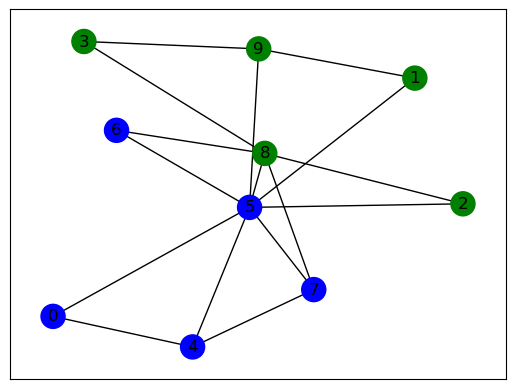

In [43]:
DrawSolution(I, "example5.txt.part.2", "example5.part.plot.png")

In [44]:
xmin = []
print("alpha" + "\t" + "num sol" + "\t  " + "equal" + "\t  " + "cut edges")
for alpha in alpha_values:
    
    Q =QMatrix("example5.txt", alpha, beta)
    num_sols, xmin_aux, Egap = QUBOSolution(Q, 1e-2)
    xmin.append(xmin_aux)
    solution = CheckIfEqual("example5.txt.part.2", xmin_aux)

    edge_list = []
    for vect in xmin_aux:
        edge_list.append(NumberCutEdges(vect,I))
    cut_edge_min = np.amin(edge_list) 
    index = np.where(edge_list == cut_edge_min)  
        
    print("{0:.2f}".format(alpha)+ "\t   " + str(num_sols) + "\t  " + str(solution) + "\t     " + str(cut_edge_min))

alpha	num sol	  equal	  cut edges
0.00	   2	  False	     0
0.11	   2	  False	     0
0.21	   2	  False	     3
0.32	   2	  False	     3
0.43	   2	  False	     3
0.54	   2	  False	     3
0.64	   2	  False	     3
0.75	   8	  False	     5
0.86	   8	  False	     5
0.96	   8	  False	     5
1.07	   10	  True	     6
1.18	   10	  True	     6
1.29	   10	  True	     6
1.39	   10	  True	     6
1.50	   10	  True	     6


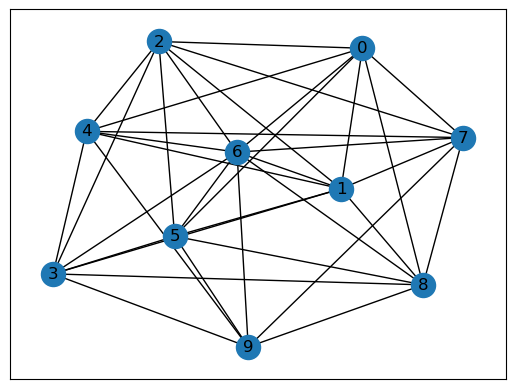

In [45]:
n = 10
p = 0.9
J = RandomGraphGenerator(n, p)
NetworkToFile(J, "example6.txt")
DrawNetwork(J, "example6.png")

In [46]:
beta = 1
alpha_values = np.linspace(0, 1.5, 15)

In [47]:
#METIS solution
GraphPartitioning("example6.txt", 2)

******************************************************************************
METIS 5.0 Copyright 1998-13, Regents of the University of Minnesota
 (HEAD: , Built on: Nov  5 2021, 13:09:47)
 size of idx_t: 32bits, real_t: 64bits, idx_t *: 64bits

Graph Information -----------------------------------------------------------
 Name: example6.txt, #Vertices: 10, #Edges: 36, #Parts: 2

Options ---------------------------------------------------------------------
 ptype=kway, objtype=cut, ctype=shem, rtype=greedy, iptype=metisrb
 dbglvl=0, ufactor=1.030, no2hop=NO, minconn=NO, contig=NO, nooutput=NO
 seed=-1, niter=10, ncuts=1

Direct k-way Partitioning ---------------------------------------------------
 - Edgecut: 16, communication volume: 10.

 - Balance:
     constraint #0:  1.000 out of 0.200

 - Most overweight partition:
     pid: 0, actual: 5, desired: 5, ratio: 1.00.

 - Subdomain connectivity: max: 1, min: 1, avg: 1.00

 - Each partition is contiguous.

Timing Information ---------

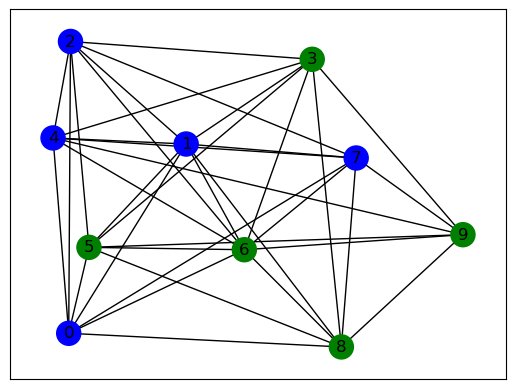

In [48]:
DrawSolution(J, "example6.txt.part.2", "example6.part.plot.png")

In [49]:
xmin = []
print("alpha" + "\t" + "num sol" + "\t  " + "equal" + "\t  " + "cut edges")
for alpha in alpha_values:
    
    Q =QMatrix("example6.txt", alpha, beta)
    num_sols, xmin_aux, Egap = QUBOSolution(Q, 1e-2)
    xmin.append(xmin_aux)
    solution = CheckIfEqual("example6.txt.part.2", xmin_aux)

    edge_list = []
    for vect in xmin_aux:
        edge_list.append(NumberCutEdges(vect,J))
    cut_edge_min = np.amin(edge_list) 
    index = np.where(edge_list == cut_edge_min)  
        
    print("{0:.2f}".format(alpha)+ "\t   " + str(num_sols) + "\t  " + str(solution) + "\t     " + str(cut_edge_min))

alpha	num sol	  equal	  cut edges
0.00	   2	  False	     0
0.11	   2	  False	     0
0.21	   2	  False	     0
0.32	   2	  False	     0
0.43	   2	  False	     0
0.54	   2	  False	     0
0.64	   2	  False	     15
0.75	   2	  False	     15
0.86	   2	  False	     15
0.96	   2	  False	     15
1.07	   2	  True	     16
1.18	   2	  True	     16
1.29	   2	  True	     16
1.39	   2	  True	     16
1.50	   2	  True	     16


In [50]:
balance_list = []
connected_list = []
for item in xmin:
    b1 = []
    c1 = []
    for sol in item:
        b1.append(IsBalanced(sol))
        c1.append(IsConnected(sol, J))
        
    temp1 = True
    
    for i in b1:
        if temp1 != i:
            temp1 = False
            break;
    temp2 = True
    
    for i in c1:
        if temp2 != i:
            temp2 = False
            break;
            
    balance_list.append(temp1)
    connected_list.append(temp2)
    
print("All balanced?")  
print(balance_list)
print("\n")

print("All connected?")  
print(connected_list) 

All balanced?
[False, False, False, False, False, False, False, False, False, False, True, True, True, True, True]


All connected?
[False, False, False, False, False, False, True, True, True, True, True, True, True, True, True]


## METIS vs QUBO

We will now generate 10 random graphs of $n = 10$ using Erdös-Rényi model for p values of 0.5 and 0.8. We will fix $\alpha = 1.25$ and $\beta = 1$.

In [78]:
n = 10
p = [0.5, 0.8]
alpha = 1.25
beta = 1

### p = 0.5

In [79]:
G = []

for i in range(10):
    G.append(RandomGraphGenerator(n, p[0]))
    NetworkToFile(G[i], "example3-" + str(i+1) + ".txt")
    
    #METIS solution
    GraphPartitioning("example3-" + str(i+1) + ".txt", 2) 

******************************************************************************
METIS 5.0 Copyright 1998-13, Regents of the University of Minnesota
 (HEAD: , Built on: Nov  5 2021, 13:09:47)
 size of idx_t: 32bits, real_t: 64bits, idx_t *: 64bits

Graph Information -----------------------------------------------------------
 Name: example3-1.txt, #Vertices: 10, #Edges: 22, #Parts: 2

Options ---------------------------------------------------------------------
 ptype=kway, objtype=cut, ctype=shem, rtype=greedy, iptype=metisrb
 dbglvl=0, ufactor=1.030, no2hop=NO, minconn=NO, contig=NO, nooutput=NO
 seed=-1, niter=10, ncuts=1

Direct k-way Partitioning ---------------------------------------------------
 - Edgecut: 7, communication volume: 10.

 - Balance:
     constraint #0:  1.000 out of 0.200

 - Most overweight partition:
     pid: 0, actual: 5, desired: 5, ratio: 1.00.

 - Subdomain connectivity: max: 1, min: 1, avg: 1.00

 - Each partition is contiguous.

Timing Information --------

Timing Information ----------------------------------------------------------
  I/O:          		   0.001 sec
  Partitioning: 		   0.000 sec   (METIS time)
  Reporting:    		   0.000 sec

Memory Information ----------------------------------------------------------
  Max memory used:		   0.051 MB
******************************************************************************


In [80]:
xmin = []
print("num solutions" + "\t" + "equal" + "\t" + "cut edges")

for i in range(10):
    Q =QMatrix("example3-" + str(i+1) + ".txt", alpha, beta)
    num_sols, xmin_aux, Egap = QUBOSolution(Q, 1e-2)
    xmin.append(xmin_aux)
    solution = CheckIfEqual("example3-" + str(i+1) + ".txt.part.2", xmin_aux)
    
    edge_list = []
    for vect in xmin_aux:
        edge_list.append(NumberCutEdges(vect, G[i]))
    cut_edge_min = np.amin(edge_list) 
    index = np.where(edge_list == cut_edge_min)
        
    print("\t" + str(num_sols) + "\t" + str(solution) + "\t   " + str(cut_edge_min))     

num solutions	equal	cut edges
	2	True	   7
	2	True	   11
	4	True	   10
	2	True	   9
	2	True	   9
	2	True	   9
	4	True	   7
	2	True	   6
	2	True	   9
	2	True	   5


### p = 0.8

In [83]:
G = []

for i in range(10):
    G.append(RandomGraphGenerator(n, p[1]))
    NetworkToFile(G[i], "example4-" + str(i+1) + ".txt")
    
    #METIS solution
    GraphPartitioning("example4-" + str(i+1) + ".txt", 2) 

******************************************************************************
METIS 5.0 Copyright 1998-13, Regents of the University of Minnesota
 (HEAD: , Built on: Nov  5 2021, 13:09:47)
 size of idx_t: 32bits, real_t: 64bits, idx_t *: 64bits

Graph Information -----------------------------------------------------------
 Name: example4-1.txt, #Vertices: 10, #Edges: 34, #Parts: 2

Options ---------------------------------------------------------------------
 ptype=kway, objtype=cut, ctype=shem, rtype=greedy, iptype=metisrb
 dbglvl=0, ufactor=1.030, no2hop=NO, minconn=NO, contig=NO, nooutput=NO
 seed=-1, niter=10, ncuts=1

Direct k-way Partitioning ---------------------------------------------------
 - Edgecut: 15, communication volume: 9.

 - Balance:
     constraint #0:  1.000 out of 0.200

 - Most overweight partition:
     pid: 0, actual: 5, desired: 5, ratio: 1.00.

 - Subdomain connectivity: max: 1, min: 1, avg: 1.00

 - Each partition is contiguous.

Timing Information --------

Timing Information ----------------------------------------------------------
  I/O:          		   0.001 sec
  Partitioning: 		   0.000 sec   (METIS time)
  Reporting:    		   0.000 sec

Memory Information ----------------------------------------------------------
  Max memory used:		   0.051 MB
******************************************************************************


In [84]:
xmin = []
print("num solutions" + "\t" + "equal" + "\t" + "cut edges")

for i in range(10):
    Q =QMatrix("example4-" + str(i+1) + ".txt", alpha, beta)
    num_sols, xmin_aux, Egap = QUBOSolution(Q, 1e-2)
    xmin.append(xmin_aux)
    solution = CheckIfEqual("example4-" + str(i+1) + ".txt.part.2", xmin_aux)
    
    edge_list = []
    for vect in xmin_aux:
        edge_list.append(NumberCutEdges(vect, G[i]))
    cut_edge_min = np.amin(edge_list) 
    index = np.where(edge_list == cut_edge_min)
        
    print("\t" + str(num_sols) + "\t" + str(solution) + "\t   " + str(cut_edge_min))     

num solutions	equal	cut edges
	2	True	   15
	12	True	   20
	2	False	   13
	4	True	   18
	8	True	   16
	2	True	   14
	14	True	   19
	4	True	   15
	2	True	   17
	6	True	   19
